In [1]:
import kwant
import numpy as np
import matplotlib.pyplot as plt
import tinyarray

sigma_0 = tinyarray.array([[1, 0], [0, 1]])
sigma_x = tinyarray.array([[0, 1], [1, 0]])
sigma_y = tinyarray.array([[0, -1j], [1j, 0]])
sigma_z = tinyarray.array([[1, 0], [0, -1]])

I_4=tinyarray.array(np.kron(sigma_0, sigma_0))
gamma_1 = tinyarray.array(np.kron(sigma_0, sigma_z))   
gamma_2 = tinyarray.array(np.kron(sigma_z, sigma_z))  
gamma_3 = tinyarray.array(np.kron(sigma_0, sigma_y))
gamma_4 = tinyarray.array(np.kron(sigma_0, sigma_x))

B=-300
g=300
las=1
width=30
c=1.0

lat = kwant.lattice.square(a=las,norbs=4)  # 定义晶格

In [2]:
def make_syst(m,width=50,length=100):
    
    #EG能
    EG_onsite    = (4*c)/las**2 * I_4
    EG_hopping_x = -c/(las**2)*I_4
    EG_hopping_y = -c/(las**2)*I_4 
    
    #TI能
    TI_onsite    = m / 2 * gamma_1 - (4 * B) / (las ** 2) * gamma_2
    TI_hopping_x = B / (las ** 2) * gamma_2 + 1j * g / (2 * las) * gamma_3
    TI_hopping_y = B / (las ** 2) * gamma_2 - 1j * g / (2 * las) * gamma_4

    
    #直接cteat the scattering center
    # 1)添加onsite点
    syst =kwant.Builder()
    for x in range(1, length + 1):
        for y in range(1, width + 1):
            is_on_boundary = (x == 1 or x == length or y == 1 or y == width) ##布尔值，判断是否在边界上
           
            if is_on_boundary:
                syst[lat(x, y)] = EG_onsite
            else:
                syst[lat(x, y)] = TI_onsite
    
    # 2）添加hoping点，分层添加矩阵
    for x in range(1, length + 1):
        for y in range(1, width + 1):
            if x < length:
                if is_on_boundary:
                    syst[lat(x, y), lat(x + 1, y)] = EG_hopping_x
                else:
                    syst[lat(x, y), lat(x + 1, y)] = TI_hopping_x
            if y < width:
                if is_on_boundary:
                    syst[lat(x, y), lat(x, y + 1)] = EG_hopping_y
                else:
                    syst[lat(x, y), lat(x, y + 1)] = TI_hopping_y
    
    #lead能量模型
    def model_lead():
        structure=kwant.lattice.square(las,norbs=4)
        model_sym= kwant.TranslationalSymmetry(structure.vec((-1,0)),structure.vec((0,-1)))
        model_1= kwant.Builder(model_sym)

        model_1[structure(0, 0)] = TI_onsite
        model_1[kwant.builder.HoppingKind((1,0), structure)]  = TI_hopping_x
        model_1[kwant.builder.HoppingKind((0,1), structure)]  = TI_hopping_y

        return model_1

    ##create the leads
    width_lead = length//5 

    lead0= kwant.Builder(kwant.TranslationalSymmetry((-1,0)))
    lead1= kwant.Builder(kwant.TranslationalSymmetry((0,1)))
    lead2= kwant.Builder(kwant.TranslationalSymmetry((0,1)))

    def shape_lead0(site):
        x, y = site.pos
        return 0 < y <= width

    def shape_lead1(site):
        x, y = site.pos
        return width_lead < x <= 2*width_lead

    def shape_lead2(site):
        x, y = site.pos
        return 3*width_lead < x <= 4*width_lead

    lead0.fill(model_lead(), shape_lead0, (0, 1))
    lead1.fill(model_lead(), shape_lead1, (width_lead+1, 0))
    lead2.fill(model_lead(), shape_lead2, (3*width_lead+1, 0))

    ########### create the six-terminal device
    for lead in [lead0,lead1,lead2, lead0.reversed(),lead2.reversed(),lead1.reversed()]:
        syst.attach_lead(lead)

    return syst.finalized()  


d:\MiniforgeConda\envs\xxy\lib\site-packages\kwant\_plotter.py:77: RuntimeWarning: plotly is not available, if other engines are unavailable, only iterator-providing functions will work
  warnings.warn("plotly is not available, if other engines are unavailable,"


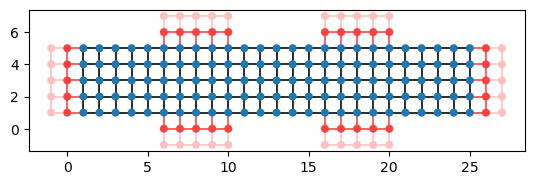

In [3]:
syst1=make_syst(50, 5,25)  
kwant.plot(syst1) ;

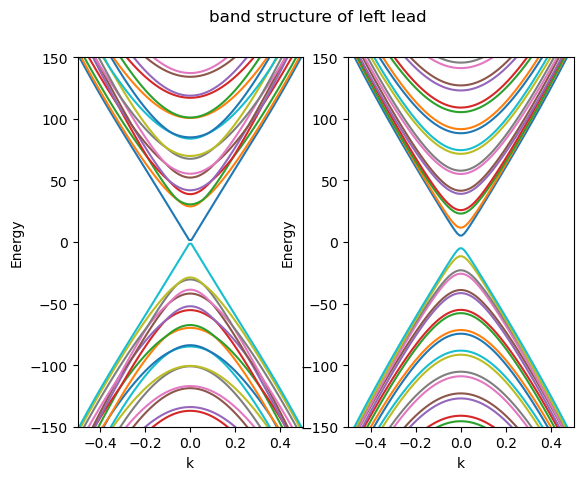

In [14]:
# 能带结构
fig, (ax1,ax2) = plt.subplots(1,2)
fig.suptitle('band structure of left lead')
a_x=0.5
a_y=150
for ax in (ax1,ax2):
    ax.set_xlabel('k')
    ax.set_ylabel('Energy')
    ax.set_ylim(-a_y,a_y)
    ax.set_xlim(-a_x,a_x)

syst2=make_syst(50,60,300).leads[0] #提取系统的第一个引线
syst3=make_syst(10,60,300).leads[0]

kwant.plotter.bands(syst2,momenta=np.linspace(-a_x, a_x, 100), ax=ax1);
kwant.plotter.bands(syst3,momenta=np.linspace(-a_x, a_x, 100), ax=ax2);